In [99]:
pwd

'/data2/mito_lineage/Analysis/multiplex/results/jan21_2021/chrM/P2_cellSNP_minC200_minAF0.01'

In [1]:
# Parameters
INDIR=""
N_DONORS=4
OUTDIR=""

In [ ]:
from os.path import join, exists, dirname

In [ ]:
AD_F = join(INDIR, AD_F)
DP_F = join(INDIR, DP_F)
cell_inds_names = join(INDIR,"cell_indices_*.txt")

# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

In [16]:
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

print(vireoSNP.__version__)

import pandas as pd


0.4.2


In [3]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

In [4]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()

AD_shape = AD.todense().shape

In [21]:
cells = pd.read_csv(join(dirname(AD_F), "cellSNP.samples.tsv"), header=None)
cells

,0
0,AAACGAAAGAGGTCCA-1
1,AAACGAAAGCGATACG-1
2,AAACGAAAGTCGTGAG-1
3,AAACGAACAATAGTGA-1
4,AAACGAACACAATAAG-1
...,...
6870,TTTGTGTTCCAAACCA-1
6871,TTTGTGTTCCGATGCG-1
6872,TTTGTGTTCCTAGAGT-1
6873,TTTGTGTTCGCTCGGA-1


## New implementation in v0.3.0

In [6]:
from vireoSNP import Vireo

Note, there are a few key parameters:

* `n_donor`: it means number of clones here, but you need to determine yourself. You can choose the one with highest ELBO (see next section)
* `n_GT`: number of different genotype. For somatic mutations, we could assume that there are only two, namely present or absent
* `is_theta_ASE`: whether allelic ratio is variant specific. For mitochondrial mutations, we choose True as allelic ratio can different from variant to variant

### Multiple initialization is needed to avoid local optima

In [7]:
np.random.seed(1)

n_initials = 50
_models_all = []
for i in range(n_initials):
    _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=N_DONORS, n_GT=2,
                     fix_beta_sum=False, ASE_mode=True)
    _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
    _modelCA.fit(AD, DP, min_iter=20, verbose=False, delay_fit_theta=0)
    _models_all.append(_modelCA)

In [8]:
## Choose the model giving highest ELBO

_idx = np.argmax([x.ELBO_[-1] for x in _models_all])
modelCA = _models_all[_idx]
_losses = modelCA.ELBO_

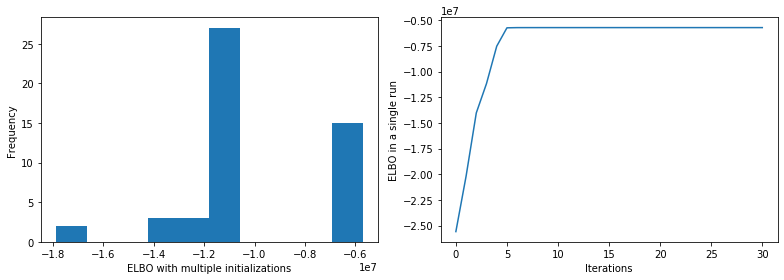

In [9]:
fig = plt.figure(figsize=(11, 4))
plt.subplot(1, 2, 1)
plt.hist([x.ELBO_[-1] for x in _models_all])
plt.ylabel("Frequency")
plt.xlabel("ELBO with multiple initializations")

plt.subplot(1, 2, 2)
plt.plot(_losses)
plt.xlabel("Iterations")
plt.ylabel("ELBO in a single run")

plt.tight_layout()
plt.show()

In [10]:
print(modelCA.beta_mu),
print(modelCA.beta_sum)

[[0.88238 0.01623]
 [0.03759 0.93691]
 [0.88731 0.02828]
 [0.87865 0.01607]
 [0.02757 0.91787]
 [0.92073 0.02836]
 [0.88780 0.01547]
 [0.22108 0.00146]
 [0.92582 0.03382]
 [0.01174 0.01730]
 [0.02980 0.03678]
 [0.01441 0.01076]
 [0.02409 0.04852]
 [0.01070 0.02840]
 [0.10864 0.67668]
 [0.01280 0.01380]
 [0.01568 0.01687]
 [0.01478 0.01618]
 [0.01192 0.01210]
 [0.01818 0.01994]
 [0.01020 0.01115]
 [0.01828 0.01898]
 [0.01881 0.01920]
 [0.01096 0.01166]
 [0.01060 0.01104]
 [0.01188 0.01200]
 [0.93966 0.03151]
 [0.01696 0.01867]
 [0.02247 0.02490]
 [0.02324 0.02699]
 [0.00150 0.09029]
 [0.03429 0.05260]
 [0.00882 0.01520]
 [0.04792 0.02245]
 [0.01155 0.02467]
 [0.01828 0.00892]
 [0.04551 0.00788]
 [0.00650 0.02643]
 [0.01073 0.02642]
 [0.00733 0.02303]
 [0.00809 0.01863]
 [0.88500 0.01609]
 [0.03802 0.93314]
 [0.01871 0.02017]
 [0.01070 0.01115]
 [0.93120 0.03619]
 [0.01679 0.88412]
 [0.93376 0.02965]
 [0.93160 0.03749]
 [0.01236 0.01334]
 [0.01083 0.01166]
 [0.43487 0.43908]
 [0.91967 0.

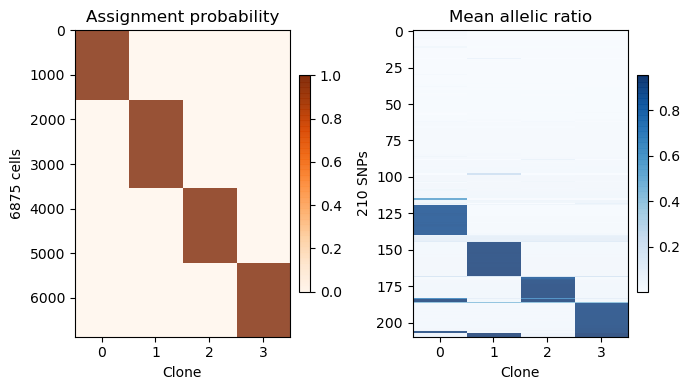

In [11]:
import matplotlib.pyplot as plt
from vireoSNP.plot.base_plot import heat_matrix

fig = plt.figure(figsize=(7, 4), dpi=100)
plt.subplot(1, 2, 1)
im = heat_matrix(modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(modelCA.n_cell))
plt.xticks(range(modelCA.n_donor))


plt.subplot(1, 2, 2)
AF_SNPs = np.sum(modelCA.GT_prob * 
                 np.expand_dims(modelCA.beta_mu, 1), axis=2)
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(modelCA.n_var))
plt.xticks(range(modelCA.n_donor))

plt.tight_layout()
plt.show()

## Add in cell IDs

In [ ]:

in_cell_f = glob(cell_inds_names)
print('cell inds', in_cell_f)
in_cell_names = []
cell_map = {}
for curr_cell_f in in_cell_f:
    print(curr_cell_f)
    with open(curr_cell_f, "r") as f:
        count = 0
        lines = []
        for line in f: 
            if count == 0:
                curr_f = line.strip()
            else:
                lines.append(line.strip().split(','))
            count += 1
    curr_df = pd.DataFrame(lines[1:], columns=lines[0])
    cell_map[curr_f] = curr_df["new index"].astype(int).values
    in_cell_names.append(curr_f)
    
max_v = 0
for i in in_cell_names:
    max_v = max(max_v, max(cell_map[i]))
    
# create index map:
cell_ind_map = {}
count = 0
for i in in_cell_names: 
    cell_ind_map[i] = count
    count += 1

cell_inds = -1*np.ones(max_v)
for i in in_cell_names:
    cell_inds[cell_map[i]-1] = cell_ind_map[i] #cell_map[i]


colors = {0:"blue", 1:"red"}
cell_colors = [colors[x] for x in cell_inds]
cell_colors = pd.Series(cell_colors, name="sample ID")
g = sns.clustermap(data=pd.DataFrame(modelCA.ID_prob, columns=[f"AF {x+1}" for x in np.arange(modelCA.ID_prob.shape[1])]), row_cluster=False, col_cluster=False,
              row_colors=cell_colors)
#plt.ylabel("Cell")
#plt.xlabel("Predicted Genotype Cluster")
g.fig.suptitle("Probability of being in cluster\nColors on left is sample ID")
g.ax_heatmap.set_xlabel("Predicted Genotype Cluster")
g.ax_heatmap.set_ylabel("Cell")
plt.savefig(join(OUTDIR, "clusters_with_sampleIDs.png"))
#plt.savefig("pseudo_multiplex_with_cellIDs.png")

## Save confident cell IDs in a line-separated text file for each cluster. Additionally, save AD and DP files. If mixed samples, create a sample id file as well for all the barcodes combined. 

In [53]:
prob_thresh=0.9
cell_clusters = dict()
cell_clusters_names = dict()
for n in range(N_DONORS):
    cell_clusters[n] = np.flatnonzero((modelCA.ID_prob[:,n]>prob_thresh))
    cell_clusters_names[n] = cells.loc[cell_clusters[n],0].values
    # Change the index to the sparse matrix index
    curr_ad = pd.DataFrame(AD.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Position", value_name="Count").rename({"index":"Cell"}, axis=1)
    curr_dp = pd.DataFrame(DP.todense()[:, cell_clusters[n]]).reset_index().melt(id_vars='index', var_name="Position", value_name="Count").rename({"index":"Cell"}, axis=1)
    print(f"Cluster {n}: {len(cell_clusters[n])} cells ")
    print(curr_dp.shape)
    print(curr_ad.shape)
    
    cell_clusters[n] += 1
    # Get their IDs 
    if OUTDIR != "" and exists(OUTDIR):
        curr_out = join(OUTDIR, f"cluster{n}_cells.txt")
        curr_str = "\n".join(cell_clusters_names[n].astype(str))
        with open(curr_out,"w") as f:
            f.write(curr_str)
        
        curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
        curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
        #curr_ad.to_csv(join(OUTDIR, f"cluster{n}.AD.txt"), sep="\t")
        #curr_dp.to_csv(join(OUTDIR, f"cluster{n}.DP.txt"), sep="\t")
        
        header = "%%MatrixMarket matrix coordinate integer general\n%\n"

        if os.path.exists(curr_ad_f):
            os.remove(curr_ad_f)
        if os.path.exists(curr_dp_f):
            os.remove(curr_dp_f)

        with open(curr_ad_f, 'a') as file:
            file.write(header)
            curr_ad = pd.concat((pd.DataFrame(
                {"Position": curr_ad["Position"].max(),
                 "Cell": curr_ad["Cell"].max(),
                 "Count": curr_ad.shape[0]}, index=["Meta"]),
                                 curr_ad.sort_values(["Position", "Cell"])))
            curr_ad.to_csv(file, sep="\t", header=False, index=False)

        with open(curr_dp_f, 'a') as file:
            file.write(header)
            curr_dp = pd.concat((pd.DataFrame(
                {"Position": curr_dp["Position"].max(),
                 "Cell": curr_dp["Cell"].max(),
                 "Count": curr_dp.shape[0]}, index=["Meta"]),
                                 curr_dp.sort_values(["Position", "Cell"])))
            curr_dp.to_csv(file, sep="\t", header=False, index=False)

if OUTDIR!="":
    pd.DataFrame(AF_SNPs, columns = [f"Cluster {x}" for x in range(AF_SNPs.shape[1])]).to_csv(join(OUTDIR, "AF_SNPs.csv"), index=False)
cell_clusters_names

Cluster 0: 1574 cells 
(330540, 3)
(330540, 3)
Cluster 1: 1957 cells 
(410970, 3)
(410970, 3)
Cluster 2: 1686 cells 
(354060, 3)
(354060, 3)
Cluster 3: 1656 cells 
(347760, 3)
(347760, 3)


{0: array(['AAACGAAAGCGATACG-1', 'AAACGAAGTACCAAGG-1', 'AAACTCGCACAAGGGT-1',
        ..., 'TTTGTGTTCACTACCC-1', 'TTTGTGTTCCAAACCA-1',
        'TTTGTGTTCCGATGCG-1'], dtype=object),
 1: array(['AAACGAAAGTCGTGAG-1', 'AAACGAACACAATAAG-1', 'AAACGAAGTAAGTCTC-1',
        ..., 'TTTGTGTAGACCGCAA-1', 'TTTGTGTTCCTAGAGT-1',
        'TTTGTGTTCGCTCGGA-1'], dtype=object),
 2: array(['AAACGAACACTGATAC-1', 'AAACGAACAGTAACCT-1', 'AAACGAAGTCCCGTGA-1',
        ..., 'TTTGGTTTCCTGACCT-1', 'TTTGTGTAGACTTCCA-1',
        'TTTGTGTTCTTCCACG-1'], dtype=object),
 3: array(['AAACGAAAGAGGTCCA-1', 'AAACGAACAATAGTGA-1', 'AAACGAACATCGTGAT-1',
        ..., 'TTTGGTTCAGTGCGTC-1', 'TTTGGTTCATGGATGG-1',
        'TTTGGTTTCGCGGCAT-1'], dtype=object)}

## Run each lineage separately

In [ ]:
for n in range(N_DONORS):
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
    curr_ad = mmread(AD_F).tocsc()
    curr_dp = mmread(DP_F).tocsc()
    run_elbo(curr_ad, curr_dp, join(OUTDIR, f"cluster{n}_lineage_elbow.png") )

### Run lineage tracing for each cluster individually

def run_elbo(ad, dp, out_f="", n_clone_list=None):
    n_initials = 50
    if n_clone_list is None:
        n_clone_list = np.arange(1,7)
    _ELBO_mat = [] 
    for k in n_clone_list:
        _elbo_temp = []
        for i in range(50):
            _modelCA = Vireo(n_var=ad.todense().shape[0], n_cell=ad.todense().shape[1], n_donor=k, n_GT=2,
                             fix_beta_sum=False, ASE_mode=True)
            _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
            _modelCA.fit(ad, dp, min_iter=20, verbose=False)
            _elbo_temp.append(_modelCA.ELBO_[-1])
        _ELBO_mat.append(_elbo_temp)
    
    plt.boxplot(_ELBO_mat)
    plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
    #plt.xticks(n_clone_list)
    plt.gca().set_xticklabels(n_clone_list)
    plt.ylabel("ELBO")
    plt.xlabel("n_clones")
    plt.show()
    if out_f != "":
        plt.savefig(out_f)
    return _ELBO_mat, n_clone_list

In [ ]:
np.sum(modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0])

### See if the N_DONOR satisfies the elbow loss rule
We can choose the number of clones where ELBO stops increasing. Here, the best number of clone is 3.

Note, for a certain number of clone, e.g., n_clone=3, the ELBO may not the same for multiple initializations. This is becaused VI can only guarantee a local optima, so please choose the highest ELBO for each `n_clone` to represent its "global" optima.

In [72]:
n_initials = 50
n_clone_list = np.arange(N_DONORS-2, N_DONORS+3)

_ELBO_mat = [] 
for k in n_clone_list:
    _elbo_temp = []
    for i in range(50):
        _modelCA = Vireo(n_var=AD_shape[0], n_cell=AD_shape[1], n_donor=k, n_GT=2,
                         fix_beta_sum=False, ASE_mode=True)
        _modelCA.set_prior(beta_mu_prior=np.array([[0.01, 0.5]]))
        _modelCA.fit(AD, DP, min_iter=20, verbose=False)
        _elbo_temp.append(_modelCA.ELBO_[-1])
    _ELBO_mat.append(_elbo_temp)

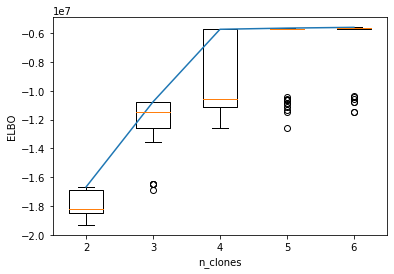

In [98]:
plt.boxplot(_ELBO_mat)
plt.plot(np.arange(1,len(n_clone_list)+1), np.max(_ELBO_mat, axis=1))
#plt.xticks(n_clone_list)
plt.gca().set_xticklabels(n_clone_list)
plt.ylabel("ELBO")
plt.xlabel("n_clones")
plt.show()